# Consensus Clustering

In this notebook, we will determine the mean partition score of the cluster assignments that we discovered as we iterated through gamma parameters. Here is what we did:
- We iterated through values of gamma ranging from 1 to 10 by increments of 0.01.
- For each gamma value, we ran 100 simulations such that for each simulation Louvain was applied on the dataset, the number of communities and community assignments were saved


Next, we will determine the mean partition score. This involves:

In [1]:
import json
import itertools
from collections import defaultdict
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt

def load_and_process_louvain_results(filepath):
    """
    Loads Louvain results from the specified JSON file and processes them
    into a dictionary grouped by gamma values. This version is specifically
    tailored to the user-provided nested JSON structure.

    Args:
        filepath (str): The path to the JSON file.

    Returns:
        dict: A dictionary where keys are gamma values and values are lists
              of community assignment arrays for each run.
    """
    print(f"Loading and processing data from '{filepath}'...")
    
    try:
        with open(filepath, 'r') as f:
            all_gamma_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: The file '{filepath}' is not a valid JSON file.")
        return None

    # --- Step 1: Create a master list of all unique ROIs for consistent indexing ---
    print("Scanning all runs to create a master list of ROIs...")
    all_rois = set()
    for gamma_block in all_gamma_data:
        for run in gamma_block.get('runs', []):
            if 'community_structure' in run:
                for community_rois in run['community_structure'].values():
                    all_rois.update(community_rois)
    
    # Sort the ROIs to have a canonical, fixed order. This is critical.
    sorted_rois = sorted(list(all_rois))
    roi_to_index = {roi: i for i, roi in enumerate(sorted_rois)}
    num_nodes = len(sorted_rois)

    if num_nodes == 0:
        print("Error: No ROIs found in the provided JSON structure.")
        return None
        
    print(f"Found {num_nodes} unique ROIs (nodes) across all runs.")

    # --- Step 2: Convert community structures into numerical partition arrays ---
    print("Processing runs and converting community structures to partition arrays...")
    grouped_partitions = defaultdict(list)
    for gamma_block in all_gamma_data:
        gamma = gamma_block.get('gamma_vals')
        if gamma is None:
            continue # Skip blocks that don't have a gamma value

        for run in gamma_block.get('runs', []):
            if 'community_structure' in run:
                # Create an empty partition array for this run
                partition = np.zeros(num_nodes, dtype=int)
                community_structure = run['community_structure']
                
                # Iterate through communities and assign a unique integer to each one
                # Sorting keys ensures the community indices are assigned deterministically, though it's not strictly necessary for NMI
                for community_idx, community_key in enumerate(sorted(community_structure.keys())):
                    rois_in_community = community_structure[community_key]
                    for roi_name in rois_in_community:
                        if roi_name in roi_to_index:
                            node_index = roi_to_index[roi_name]
                            partition[node_index] = community_idx
                
                grouped_partitions[gamma].append(partition)

    print(f"Successfully processed runs across {len(grouped_partitions)} unique gamma values.")
    
    return dict(grouped_partitions)


def calculate_mps(results_dict):
    """
    Calculates the Mean Partition Similarity (MPS) for each gamma value.

    Args:
        results_dict (dict): A dictionary from the processing function.

    Returns:
        dict: A dictionary where keys are gamma values and values are their MPS.
    """
    mps_scores = {}
    
    # Sort the gamma values to process them in order
    sorted_gammas = sorted(results_dict.keys())
    
    for i, gamma in enumerate(sorted_gammas):
        partitions = results_dict[gamma]
        if i%50==0:
            print(f"Calculating MPS for gamma = {gamma:.2f} ({i+1}/{len(sorted_gammas)})...")
        
        # Get all unique pairs of partitions using itertools.combinations
        if len(partitions) < 2:
            mps_scores[gamma] = None # Cannot compare if less than 2 runs
            continue
            
        partition_pairs = list(itertools.combinations(partitions, 2))
        
        # Calculate NMI for each pair. 'arithmetic' is a standard choice.
        nmi_scores = [
            normalized_mutual_info_score(p1, p2, average_method='arithmetic')
            for p1, p2 in partition_pairs
        ]
        
        # Calculate the mean of all NMI scores for this gamma
        mps_scores[gamma] = np.mean(nmi_scores)
        
    return mps_scores

In [41]:
JSON_FILE_PATH = '../output/louvain_gamma_all_runs.json'
louvain_results_efferent = load_and_process_louvain_results(JSON_FILE_PATH)

AFFERENT_FILE_PATH = '../output/louvain_gamma_all_runs_afferent.json'
louvain_results_afferent = load_and_process_louvain_results(AFFERENT_FILE_PATH)

Loading and processing data from '../output/louvain_gamma_all_runs.json'...
Scanning all runs to create a master list of ROIs...
Found 170 unique ROIs (nodes) across all runs.
Processing runs and converting community structures to partition arrays...
Successfully processed runs across 1000 unique gamma values.
Loading and processing data from '../output/louvain_gamma_all_runs_afferent.json'...
Scanning all runs to create a master list of ROIs...
Found 96 unique ROIs (nodes) across all runs.
Processing runs and converting community structures to partition arrays...
Successfully processed runs across 1000 unique gamma values.


In [42]:
def get_louvain_data(louvain_results):
    """
    Return the optimal gamma value by iterating through louvain results dictionary.

    Args:
        louvain_results (dict): A dictionary from the processing function.

    Returns:
        dict: A dictionary of the scores, optimal gamma and maximum partition score.
    """
    if louvain_results:
        # CALCULATE MEAN PARTITION SIMILARITY
        mps_values = calculate_mps(louvain_results)
        
        # Filter out any None values if they exist
        valid_mps = {g: s for g, s in mps_values.items() if s is not None}
    
        if not valid_mps:
            print("No valid MPS scores could be calculated.")
        else:
            # 3. FIND OPTIMAL GAMMA AND PLOT
            gammas = list(valid_mps.keys())
            scores = list(valid_mps.values())
    
            # Find the optimal gamma corresponding to the highest MPS score
            optimal_gamma = gammas[np.argmax(scores)]
            max_mps = max(scores)
    
            print("\n" + "="*40)
            print(f"Analysis Complete!")
            print(f"Optimal gamma found at γ = {optimal_gamma:.2f} with an MPS of {max_mps:.4f}")
            print("="*40 + "\n")
            ret_dict = {
                'scores': scores,
                'gammas': gammas,
                'optimal_gamma': optimal_gamma,
                'max_mps': max_mps
            }
            return ret_dict

In [43]:
louvain_results_efferent = get_louvain_data(louvain_results_efferent)
louvain_results_afferent = get_louvain_data(louvain_results_afferent)

Calculating MPS for gamma = 0.00 (1/1000)...
Calculating MPS for gamma = 0.50 (51/1000)...
Calculating MPS for gamma = 1.00 (101/1000)...
Calculating MPS for gamma = 1.50 (151/1000)...
Calculating MPS for gamma = 2.00 (201/1000)...
Calculating MPS for gamma = 2.50 (251/1000)...
Calculating MPS for gamma = 3.00 (301/1000)...
Calculating MPS for gamma = 3.50 (351/1000)...
Calculating MPS for gamma = 4.00 (401/1000)...
Calculating MPS for gamma = 4.50 (451/1000)...
Calculating MPS for gamma = 5.00 (501/1000)...
Calculating MPS for gamma = 5.50 (551/1000)...
Calculating MPS for gamma = 6.00 (601/1000)...
Calculating MPS for gamma = 6.50 (651/1000)...
Calculating MPS for gamma = 7.00 (701/1000)...
Calculating MPS for gamma = 7.50 (751/1000)...
Calculating MPS for gamma = 8.00 (801/1000)...
Calculating MPS for gamma = 8.50 (851/1000)...
Calculating MPS for gamma = 9.00 (901/1000)...
Calculating MPS for gamma = 9.50 (951/1000)...

Analysis Complete!
Optimal gamma found at γ = 0.00 with an MPS

In [44]:
# non_zero = scores[99:]

# extract values from the louvain dictionaries
afferent_scores = louvain_results_afferent['scores']
efferent_scores = louvain_results_efferent['scores']

afferent_gammas = louvain_results_afferent['gammas']
efferent_gammas = louvain_results_efferent['gammas']


Plot has been saved as 'mps_vs_gamma_plot.png'


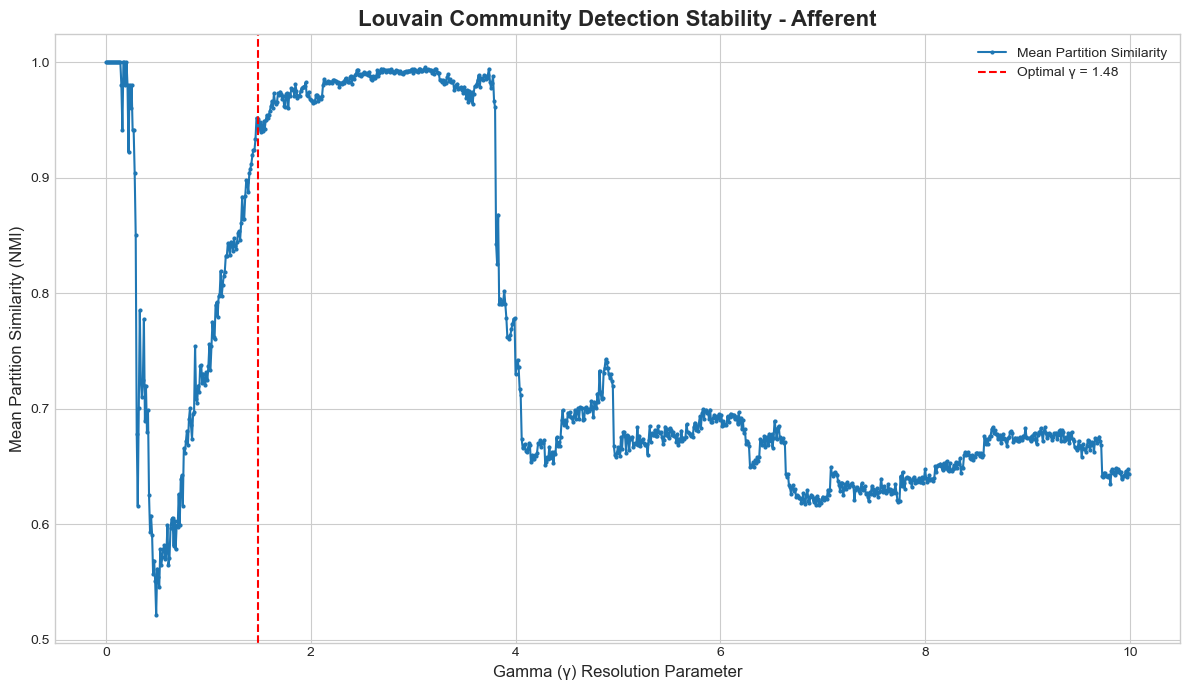

In [45]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(afferent_gammas, afferent_scores, marker='.', linestyle='-', markersize=4, label='Mean Partition Similarity')
ax.axvline(x=optimal_gamma, color='r', linestyle='--', 
           label=f'Optimal γ = {optimal_gamma:.2f}')

ax.set_title('Louvain Community Detection Stability - Afferent', fontsize=16, weight='bold')
ax.set_xlabel('Gamma (γ) Resolution Parameter', fontsize=12)
ax.set_ylabel('Mean Partition Similarity (NMI)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Improve layout and save the figure
plt.tight_layout()
plt.savefig('../output/mps_vs_gamma_plot_afferent.png', dpi=300)

print("Plot has been saved as 'mps_vs_gamma_plot.png'")
plt.show()

Plot has been saved as 'mps_vs_gamma_plot.png'


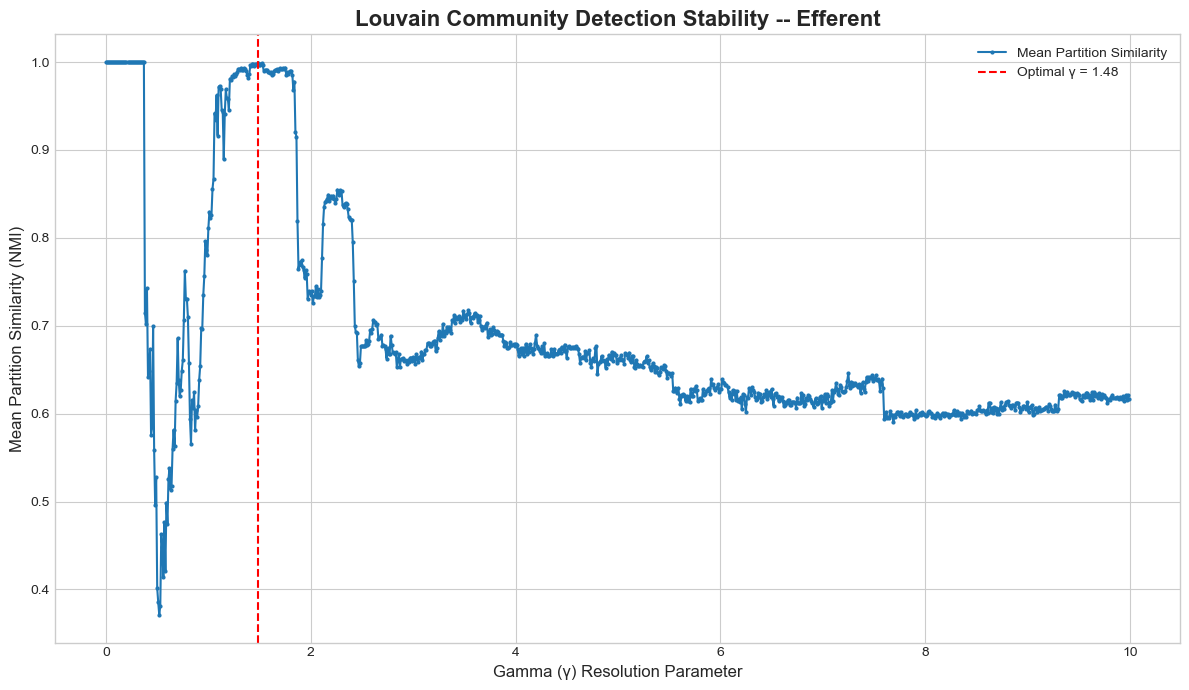

In [46]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(efferent_gammas, efferent_scores, marker='.', linestyle='-', markersize=4, label='Mean Partition Similarity')
ax.axvline(x=optimal_gamma, color='r', linestyle='--', 
           label=f'Optimal γ = {optimal_gamma:.2f}')

ax.set_title('Louvain Community Detection Stability -- Efferent', fontsize=16, weight='bold')
ax.set_xlabel('Gamma (γ) Resolution Parameter', fontsize=12)
ax.set_ylabel('Mean Partition Similarity (NMI)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Improve layout and save the figure
plt.tight_layout()
plt.savefig('mps_vs_gamma_plot.png', dpi=300)

print("Plot has been saved as 'mps_vs_gamma_plot.png'")
plt.show()

## Filter gamma values to only include gammas >=1

In [47]:
# iterate through the gamma values and drop all values less than 1

filtered_gammas_efferent = []
filtered_MPS_efferent = []

for i, gamma_val in enumerate(efferent_gammas):
    if gamma_val >= 1:
        filtered_gammas_efferent.append(gamma_val)
        filtered_MPS_efferent.append(efferent_scores[i])


filtered_gammas_afferent = []
filtered_MPS_afferent = []

for i, gamma_val in enumerate(afferent_gammas):
    if gamma_val >= 1:
        filtered_gammas_afferent.append(gamma_val)
        filtered_MPS_afferent.append(afferent_scores[i])

Plot has been saved as 'mps_vs_gamma_plot.png'


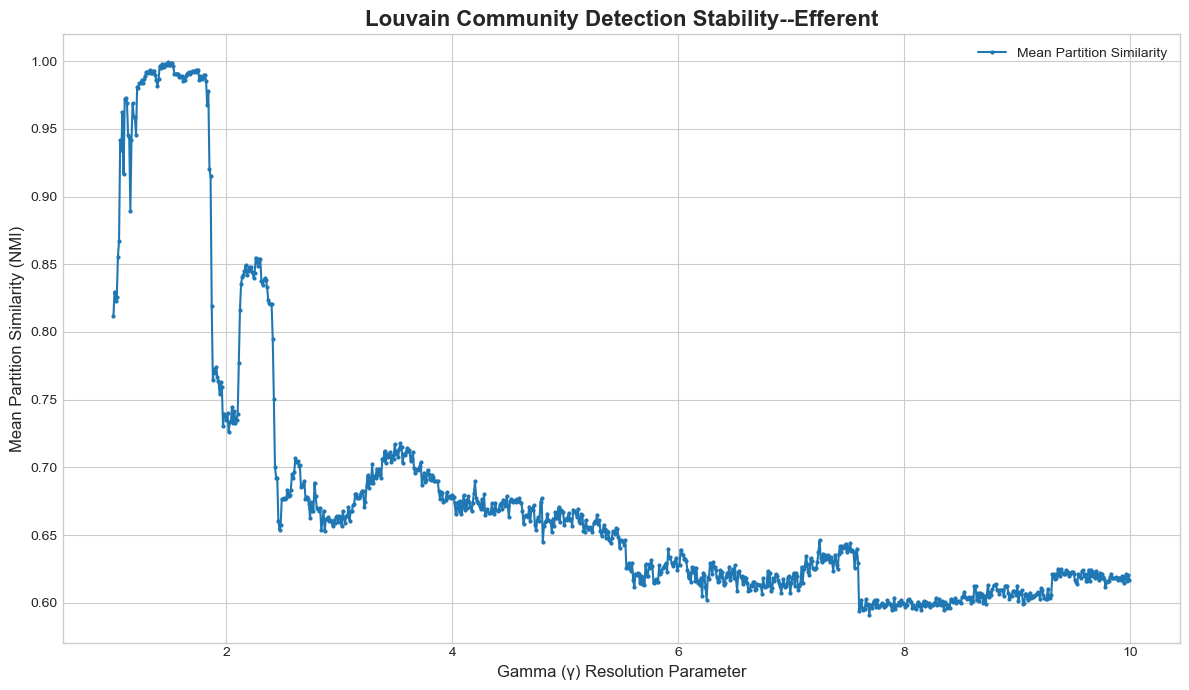

In [49]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(filtered_gammas_efferent, filtered_MPS_efferent, marker='.', linestyle='-', markersize=4, label='Mean Partition Similarity')
# ax.axvline(x=optimal_gamma, color='r', linestyle='--', 
#            label=f'Optimal γ = {optimal_gamma:.2f}')

ax.set_title('Louvain Community Detection Stability--Efferent', fontsize=16, weight='bold')
ax.set_xlabel('Gamma (γ) Resolution Parameter', fontsize=12)
ax.set_ylabel('Mean Partition Similarity (NMI)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Improve layout and save the figure
plt.tight_layout()
plt.savefig('../output/mps_vs_gamma_plot_efferent.png', dpi=300)

print("Plot has been saved as 'mps_vs_gamma_plot.png'")
plt.show()

In [50]:
optimal_gamma_efferent = filtered_gammas_efferent[np.argmax(filtered_MPS_efferent)]

In [51]:
optimal_gamma_efferent

1.48

Plot has been saved as 'mps_vs_gamma_plot.png'


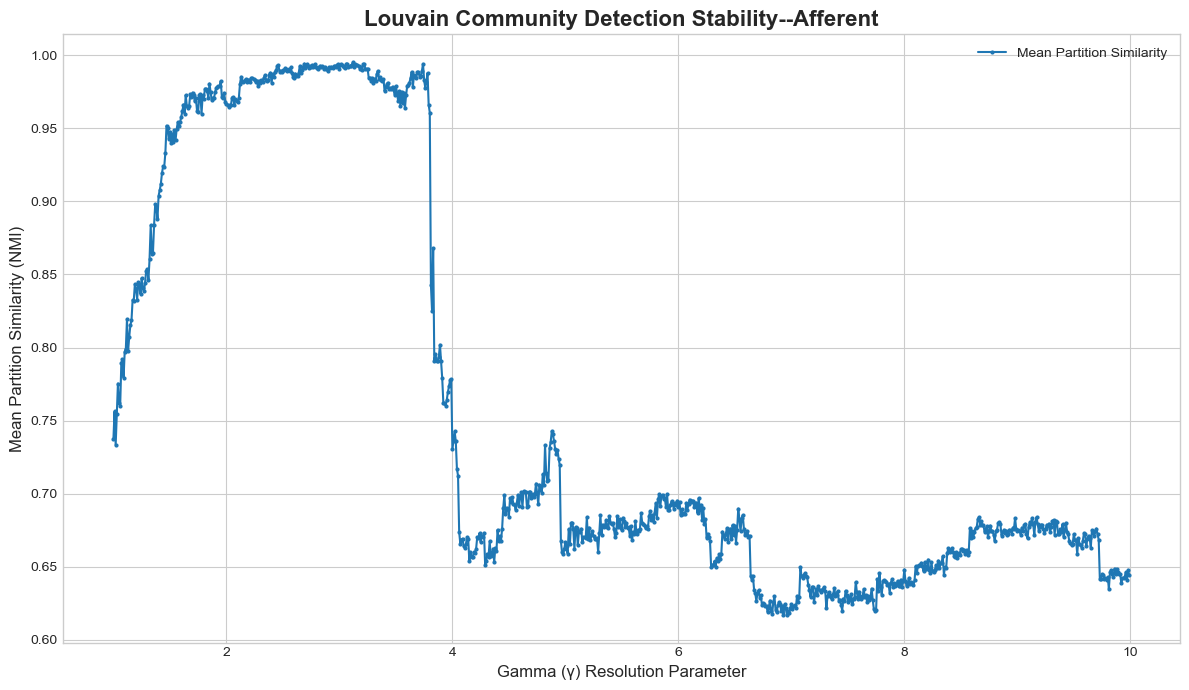

In [52]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(filtered_gammas_afferent, filtered_MPS_afferent, marker='.', linestyle='-', markersize=4, label='Mean Partition Similarity')
# ax.axvline(x=optimal_gamma, color='r', linestyle='--', 
#            label=f'Optimal γ = {optimal_gamma:.2f}')

ax.set_title('Louvain Community Detection Stability--Afferent', fontsize=16, weight='bold')
ax.set_xlabel('Gamma (γ) Resolution Parameter', fontsize=12)
ax.set_ylabel('Mean Partition Similarity (NMI)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Improve layout and save the figure
plt.tight_layout()
plt.savefig('../output/mps_vs_gamma_plot_afferent.png', dpi=300)

print("Plot has been saved as 'mps_vs_gamma_plot.png'")
plt.show()

In [53]:
optimal_gamma_afferent = filtered_gammas_afferent[np.argmax(filtered_MPS_afferent)]

In [54]:
optimal_gamma_afferent

3.12

In [2]:
from helpers import get_feature_vectors_shared_hpc, get_correlation_matrix

df_avg_to_shared, df_avg_from_shared = get_feature_vectors_shared_hpc()

cosine_shared_afferent = get_correlation_matrix(df_avg_to_shared, 'cosine')
cosine_shared_efferent = get_correlation_matrix(df_avg_from_shared, 'cosine')

afferent_connection_values = cosine_shared_afferent.values
efferent_connection_values = cosine_shared_efferent.values

In [24]:
import numpy as np
import networkx as nx
# import community as community_louvain  # This is the python-louvain package
import matplotlib.pyplot as plt
import bct

def perform_louvain_gamma_sweep():
    """
    Runs a Louvain community detection sweep over a range of gamma (resolution)
    values for two matrices and plots the results.
    """
    
    print("Starting Louvain gamma sweep...")

    # --- 1. Load or Generate Data ---
    # In a real scenario, you would load your matrices here.
    # For this example, we generate two 72x72 dummy matrices.
    # We use np.random.rand which gives values [0, 1].
    # For correlation matrices ([-1, 1]), you might use np.abs()
    # to get the strength of the connection as edge weights.
    
    # # !! REPLACE THESE LINES with your actual data !!
    # print("Generating dummy 72x72 matrices...")
    # matrix_size = 72
    # # Simulating correlation-like data, making it symmetric
    # aff_data = np.random.rand(matrix_size, matrix_size)
    # afferent_matrix = (aff_data + aff_data.T) / 2
    # np.fill_diagonal(afferent_matrix, 1) # Set diagonal to 1
    
    # eff_data = np.random.rand(matrix_size, matrix_size)
    # efferent_matrix = (eff_data + eff_data.T) / 2
    # np.fill_diagonal(efferent_matrix, 1) # Set diagonal to 1

    
    # We use the absolute value for weights, assuming connection strength
    # is what matters for community structure.
    # G_afferent = nx.from_numpy_array(np.abs(afferent_matrix))
    # G_efferent = nx.from_numpy_array(np.abs(efferent_matrix))
    
    print("Graphs created from matrices.")

    # --- 2. Define Gamma Range ---
    # np.arange(start, stop_exclusive, step)
    # We use 10.1 as the stop to ensure 10.0 is included.
    gamma_values = np.arange(0.5, 2.1, 0.1)
    
    # Lists to store the number of communities
    afferent_community_counts = []
    efferent_community_counts = []

    # --- 3. Iterate and Run Louvain ---
    print(f"Iterating over {len(gamma_values)} gamma values (from 0.5 to 10.0)...")
    
    for gamma in gamma_values:
        # Run Louvain for the afferent graph
        # The 'resolution' parameter is the gamma you referred to
        # partition_aff = community_louvain.best_partition(
        #     G_afferent, 
        #     resolution=gamma, 
        #     weight='weight'
        # )
        # # Find the number of unique communities
        # num_communities_aff = len(set(partition_aff.values()))
        # afferent_community_counts.append(num_communities_aff)

        # # Run Louvain for the efferent graph
        # partition_eff = community_louvain.best_partition(
        #     G_efferent, 
        #     resolution=gamma, 
        #     weight='weight'
        # )
        # # Find the number of unique communities
        # num_communities_eff = len(set(partition_eff.values()))
        # efferent_community_counts.append(num_communities_eff)

        # ----- Run louvain for afferent -----
        # afferent
        community_assignments_a, modularity_score_a = bct.modularity_louvain_dir(afferent_connection_values, 
                                                                    gamma=gamma, seed=42)
        # Find number of communities
        num_communities_aff = np.max(community_assignments_a)
        afferent_community_counts.append(num_communities_aff)

        # ----- Run louvain for efferent -----
        # afferent
        community_assignments_e, modularity_score_e = bct.modularity_louvain_dir(efferent_connection_values, 
                                                                    gamma=gamma, seed=42)
        # Find number of communities
        num_communities_eff = np.max(community_assignments_e)
        efferent_community_counts.append(num_communities_eff)
        
        
        if (gamma * 10) % 10 == 0: # Print progress every 1.0 gamma
             print(f"  Processed gamma = {gamma:.1f}")

    print("Iteration complete.")

    # --- 4. Plot the Results ---
    print("Generating plot...")
    plt.figure(figsize=(12, 7))
    
    plt.plot(
        gamma_values, 
        afferent_community_counts, 
        label='Afferent Communities', 
        marker='.', 
        linestyle='-'
    )
    
    plt.plot(
        gamma_values, 
        efferent_community_counts, 
        label='Efferent Communities', 
        marker='.', 
        linestyle='--'
    )
    
    plt.xlabel('Gamma (Resolution Parameter)')
    plt.ylabel('Number of Communities Detected')
    plt.title('Effect of Gamma on Louvain Community Detection')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot as a file
    plot_filename = 'louvain_gamma_vs_communities.png'
    plt.savefig(plot_filename)
    print(f"Plot saved as '{plot_filename}'")
    
    # Show the plot
    plt.show()

Starting Louvain gamma sweep...
Graphs created from matrices.
Iterating over 16 gamma values (from 0.5 to 10.0)...
Iteration complete.
Generating plot...
Plot saved as 'louvain_gamma_vs_communities.png'


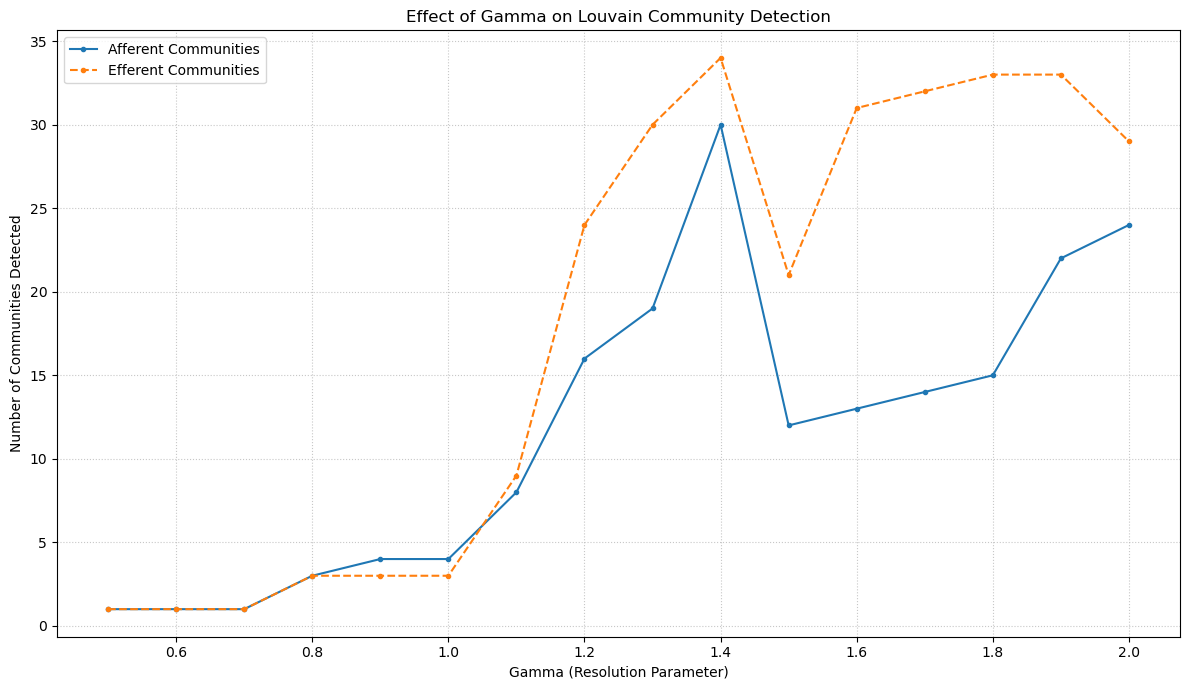

In [25]:
perform_louvain_gamma_sweep()

In [13]:
test = [34,54345,2]
np.max(test)

np.int64(54345)

In [19]:
cosine_shared_efferent

,SI,MS,NDB,BSTam,BSTju,BSTpr,BSTif,BSTtr,BSTd,LSr.m.v,...,LHAsfa,REr,REc,PVT,PT,AV,AMd,IAM,SMT,VTA
SI,1.000000,0.646762,0.628539,0.808452,0.666667,0.894427,0.942809,0.942809,0.666667,0.946729,...,0.666667,0.808452,0.608581,0.784465,0.666667,0.000000,0.666667,0.314270,0.000000,0.755929
MS,0.646762,1.000000,0.971825,0.176471,0.000000,0.650791,0.514496,0.514496,0.000000,0.500979,...,0.727607,0.588235,0.398527,0.142695,0.565916,0.485071,0.727607,0.628828,0.485071,0.458349
NDB,0.628539,0.971825,1.000000,0.171499,0.000000,0.632456,0.500000,0.500000,0.000000,0.486864,...,0.707107,0.571662,0.473365,0.138675,0.549972,0.471405,0.707107,0.611111,0.471405,0.534522
BSTam,0.808452,0.176471,0.171499,1.000000,0.970143,0.650791,0.857493,0.857493,0.970143,0.876714,...,0.242536,0.823529,0.752773,0.998868,0.727607,0.000000,0.242536,0.285831,0.000000,0.825029
BSTju,0.666667,0.000000,0.000000,0.970143,1.000000,0.447214,0.707107,0.707107,1.000000,0.774597,...,0.000000,0.727607,0.730297,0.980581,0.666667,0.000000,0.000000,0.235702,0.000000,0.755929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AV,0.000000,0.485071,0.471405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.485071,0.547723,0.000000,0.666667,1.000000,0.000000,0.942809,1.000000,0.377964
AMd,0.666667,0.727607,0.707107,0.242536,0.000000,0.894427,0.707107,0.707107,0.000000,0.516398,...,1.000000,0.485071,0.182574,0.196116,0.333333,0.000000,1.000000,0.235702,0.000000,0.377964
IAM,0.314270,0.628828,0.611111,0.285831,0.235702,0.316228,0.333333,0.333333,0.235702,0.304290,...,0.235702,0.743161,0.731564,0.277350,0.864242,0.942809,0.235702,1.000000,0.942809,0.623610
SMT,0.000000,0.485071,0.471405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.485071,0.547723,0.000000,0.666667,1.000000,0.000000,0.942809,1.000000,0.377964
